In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import lagrange #Lagrange 
from scipy.optimize import curve_fit

A_D = 1.36 * 10**6   # Константы из статьи
beta_D = 1.53
T_D = 21

param = np.array([T_D, A_D, beta_D])

h = 6.626 * 10**(-34)  # Мировые константы
k = 1.381 * 10**(-23)

def Thermal_Dust(nu):  # Спектр пыли
    x = (h * nu)/(k * T_D)
    I = A_D * x**beta_D * (x**3)/(np.exp(x) - 1)
    return I
    
x = np.linspace(10**10, 3 * 10**12, 100)
I = Thermal_Dust(x)
noise = np.random.normal(loc = 10**10, scale = 50, size = 100)

fig = plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.title('No noise')
plt.loglog(x, I, label = 'Dust')
plt.xlabel('$\\nu$, Hz', fontsize=19)
plt.ylabel('Spectral Radiance, Jy/sr', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize = 18)
plt.grid()

plt.subplot(122)
plt.title('Noise')
plt.loglog(x, I + noise * 10**(-8), label = 'Dust')
plt.xlabel('$\\nu$, Hz', fontsize=19)
plt.ylabel('Spectral Radiance, Jy/sr', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize = 18)
plt.grid()



# Пыль с шумом

[2.10002785e+01 1.36012487e+06 1.52994295e+00]
[2.10e+01 1.36e+06 1.53e+00]
Относительная ошибка [1.3261579247403871e-05, 9.181570008342319e-05, 3.728532914136795e-05]


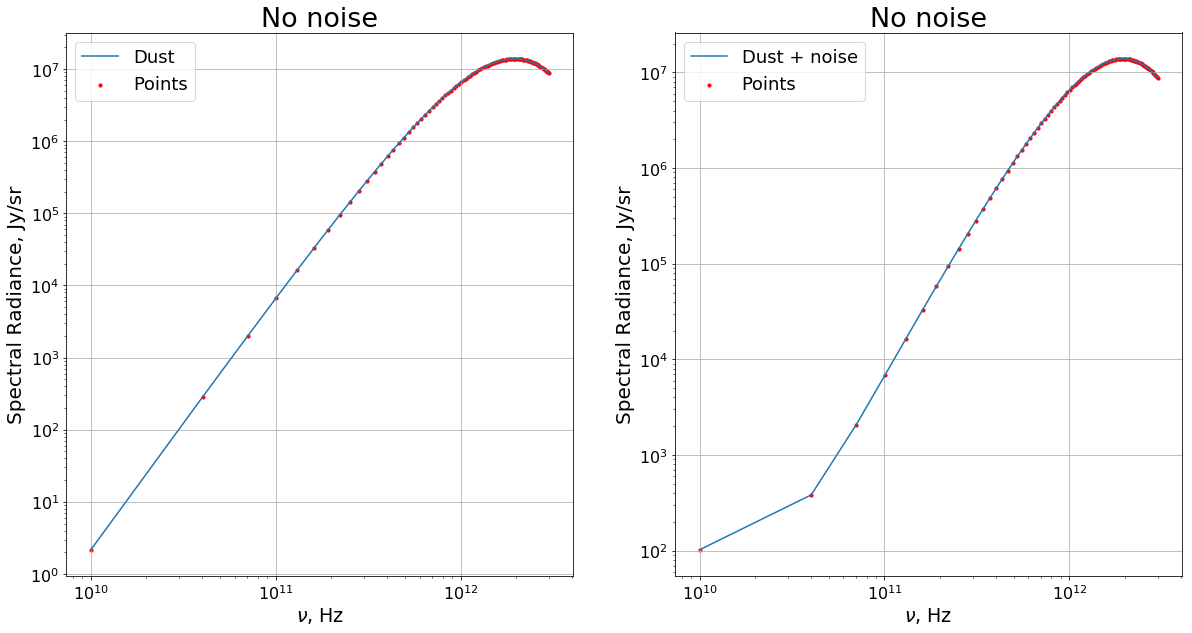

In [2]:
def Thermal_Dust_param(nu, T_D, A_D, beta_D):  # Спектр пыли c параметрами
    x = (h * nu)/(k * T_D)
    I = A_D * x**beta_D * (x**3)/(np.exp(x) - 1)
    return I

x = np.linspace(10**10, 3 * 10**12, 100)
I = Thermal_Dust(x)
I_noise = I + noise * 10**(-8)
fig = plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.loglog(x, I, label = 'Dust')
plt.scatter(x, I, label = 'Points', s = 10, c = 'r')
plt.title('No noise', fontsize = 27)
plt.xlabel('$\\nu$, Hz', fontsize=19)
plt.ylabel('Spectral Radiance, Jy/sr', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize = 18)
plt.grid()

plt.subplot(122)
plt.loglog(x, I_noise, label = 'Dust + noise')
plt.scatter(x, I_noise, label = 'Points', s = 10, c = 'r')
plt.title('No noise', fontsize = 27)
plt.xlabel('$\\nu$, Hz', fontsize=19)
plt.ylabel('Spectral Radiance, Jy/sr', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize = 18)
plt.grid()

popt, pcov = curve_fit(Thermal_Dust_param, x, I_noise)
print(popt)
print(param)
dev = list(abs(popt - param))
eps = [dev / (list(param))[n] for n, dev in enumerate(dev)]
print('Относительная ошибка', eps)

# Пыль и $\mu$ - возмущение

[2.1000000e+01 1.3600000e+06 1.5300000e+00 2.0000001e-08]
[2.10e+01 1.36e+06 1.53e+00 2.00e-08]
Относительная ошибка [1.8778629445088362e-14, 1.1418973479200812e-13, 5.979240341772085e-14, 5.0051527908708575e-08]


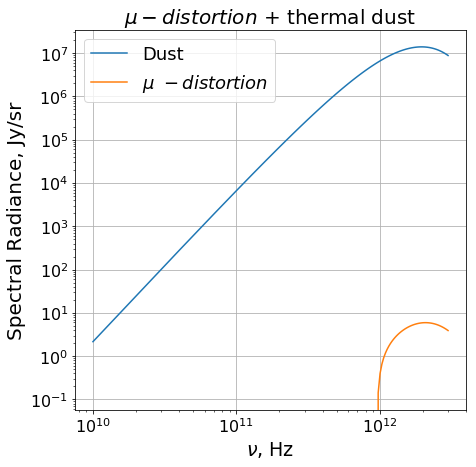

In [3]:
def Thermal_Dust_param(nu, T_D, A_D, beta_D):  # Спектр пыли c параметрами
    x = (h * nu)/(k * T_D)
    I = A_D * x**beta_D * (x**3)/(np.exp(x) - 1)
    return I


I_0 = 270 * 10**6
beta = 2.1923
mu = 2 * 10**(-8)

# Вообще в статье написано, что бетту мы знаем, а мю приняли некоторым. То есть мы знаем точно-точно это распределение? 

def mu_distortions(nu):          # То есть нет параметров, которые нужно определить? Кажется, мю это таки параметр
    x = (h * nu)/(k * T_D)
    I = I_0 * (x**4 * np.exp(x))/(np.exp(x) - 1)**2 * (1/beta - 1/x) * mu
    return I

def mu_distortions_param(nu, mu):
    x = (h * nu)/(k * T_D)
    I = I_0 * (x**4 * np.exp(x))/(np.exp(x) - 1)**2 * (1/beta - 1/x) * mu
    return I

x = np.linspace(10**10, 3 * 10**12, 100)
I_dust = Thermal_Dust(x)
I_mu = mu_distortions(x)

fig = plt.figure(figsize=(7, 7))

plt.title('$\mu-distortion$ + thermal dust', fontsize = 20)
plt.loglog(x, I_dust, label = 'Dust')
plt.loglog(x, I_mu, label = '$\mu\ - distortion$')
plt.xlabel('$\\nu$, Hz', fontsize=19)
plt.ylabel('Spectral Radiance, Jy/sr', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(fontsize = 18)
plt.grid()

# Теперь попробуем разделить два графика

def mu_dust_param(nu, T_D, A_D, beta_D, mu):
    I = Thermal_Dust_param(nu, T_D, A_D, beta_D) + mu_distortions_param(nu, mu)
    return(I)

I_tot = mu_dust_param(x, T_D, A_D, beta_D, mu)

popt, pcov = curve_fit(mu_dust_param, x, I_tot, bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, 9 * 10**(-5))))
print(popt)

param = np.array([T_D, A_D, beta_D, mu])

print(param)
dev = list(abs(popt - param))
eps = [dev / (list(param))[n] for n, dev in enumerate(dev)]
print('Относительная ошибка', eps)

# Две пыли

In [4]:
def Thermal_Dust_param(nu, T_D, A_D, beta_D):  # Спектр пыли c параметрами
    x = (h * nu)/(k * T_D)
    I = A_D * x**beta_D * (x**3)/(np.exp(x) - 1)
    return I

def Double_Dust(nu, T_D1, T_D2, A_D, beta_D):
    x1 = (h * nu)/(k * T_D1)
    x2 = (h * nu)/(k * T_D2)
    I = A_D * x1**beta_D * (x1**3)/(np.exp(x1) - 1)  + A_D * x2**beta_D * (x2**3)/(np.exp(x2) - 1)
    return I

T_D1 = 20
T_D2 = 22

x = np.linspace(10**10, 3 * 10**12, 100)
I_double_dust = Double_Dust(x, T_D1, T_D2, A_D, beta_D)

popt, pcov = curve_fit( Double_Dust, x, I_double_dust)
print(popt)

param = np.array([T_D1, T_D2, A_D, beta_D])

print(param)

[2.20e+01 2.00e+01 1.36e+06 1.53e+00]
[2.00e+01 2.20e+01 1.36e+06 1.53e+00]


# Две пыли и $\mu - $ возмущение

In [6]:
# А ВОТ ТЕПЕРЬ СТАЛО ПЛОХО  :(

def Double_Dust(nu, T_D1, T_D2, A_D, beta_D):
    x1 = (h * nu)/(k * T_D1)
    x2 = (h * nu)/(k * T_D2)
    I = A_D * x1**beta_D * (x1**3)/(np.exp(x1) - 1)  + A_D * x2**beta_D * (x2**3)/(np.exp(x2) - 1)
    return I

T_D1 = 20
T_D2 = 22

def mu_distortions_param(nu, mu):
    x = (h * nu)/(k * T_D)
    I = I_0 * (x**4 * np.exp(x))/(np.exp(x) - 1)**2 * (1/beta - 1/x) * mu
    return I

def DD_mu(nu, T_D1, T_D2, A_D, beta_D, mu):
    I = Double_Dust(nu, T_D1, T_D2, A_D, beta_D) + mu_distortions_param(nu, mu)
    return I

x = np.linspace(10**10, 3 * 10**12, 100)

I_DD_mu = DD_mu(x, T_D1, T_D2, A_D, beta_D, mu)

popt, pcov = curve_fit( DD_mu, x, I_DD_mu, bounds=((0, 0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf, 4 * 10**(-7))))
print(popt)

param = np.array([T_D1, T_D2, A_D, beta_D, mu])

print(param)
dev = list(abs(popt - param))
eps = [dev / (list(param))[n] for n, dev in enumerate(dev)]
print('Относительная ошибка', eps)

# Если взять верхнюю границу для мю = 9*10**(-5), то всё плохо. Но если взять 4*10**(-7), то хорошо.

[2.00000000e+01 2.20000000e+01 1.36000000e+06 1.53000000e+00
 2.00000001e-08]
[2.00e+01 2.20e+01 1.36e+06 1.53e+00 2.00e-08]
Относительная ошибка [6.217248937900877e-15, 2.2608177956003187e-15, 1.2326328193440157e-14, 6.24046928874271e-15, 5.2426710532333344e-09]


# Способ с использованием производных

In [38]:
# Очень не хотелось считать производную ручками(

from sympy import diff, exp 
from sympy import *
from sympy.abc import x
A_D, T_D, beta_D, nu, h, k = symbols("A_D T_D beta_D nu h k")

x = (h * nu)/(k * T_D)
I = A_D * x**beta_D * (x**3)/(exp(x) - 1)

print(diff(I, T_D, 3))
print()


A_D*h**3*nu**3*(h*nu/(T_D*k))**beta_D*(-beta_D**3 - 12*beta_D**2 - 47*beta_D - 60 + 3*beta_D**2*h*nu*exp(h*nu/(T_D*k))/(T_D*k*(exp(h*nu/(T_D*k)) - 1)) + 27*beta_D*h*nu*exp(h*nu/(T_D*k))/(T_D*k*(exp(h*nu/(T_D*k)) - 1)) + 60*h*nu*exp(h*nu/(T_D*k))/(T_D*k*(exp(h*nu/(T_D*k)) - 1)) + 3*beta_D*h**2*nu**2*exp(h*nu/(T_D*k))/(T_D**2*k**2*(exp(h*nu/(T_D*k)) - 1)) - 6*beta_D*h**2*nu**2*exp(2*h*nu/(T_D*k))/(T_D**2*k**2*(exp(h*nu/(T_D*k)) - 1)**2) + 15*h**2*nu**2*exp(h*nu/(T_D*k))/(T_D**2*k**2*(exp(h*nu/(T_D*k)) - 1)) - 30*h**2*nu**2*exp(2*h*nu/(T_D*k))/(T_D**2*k**2*(exp(h*nu/(T_D*k)) - 1)**2) + h**3*nu**3*exp(h*nu/(T_D*k))/(T_D**3*k**3*(exp(h*nu/(T_D*k)) - 1)) - 6*h**3*nu**3*exp(2*h*nu/(T_D*k))/(T_D**3*k**3*(exp(h*nu/(T_D*k)) - 1)**2) + 6*h**3*nu**3*exp(3*h*nu/(T_D*k))/(T_D**3*k**3*(exp(h*nu/(T_D*k)) - 1)**3))/(T_D**6*k**3*(exp(h*nu/(T_D*k)) - 1))



In [63]:
A_D = 1.36 * 10**6   # Константы из статьи
beta_D = 1.53
h = 6.626 * 10**(-34)  # Мировые константы
k = 1.381 * 10**(-23)

def Thermal_Dust(nu, T_D):  # Спектр пыли c параметрами
    x = (h * nu)/(k * T_D)
    I = A_D * x**beta_D * (x**3)/(np.exp(x) - 1)
    return I

def Thermal_Dust_1(nu, T_D):
    dI_dT = -A_D*beta_D*h**3*nu**3*(h*nu/(T_D*k))**beta_D/(T_D**4*k**3*(np.exp(h*nu/(T_D*k)) - 1)) - 3*A_D*h**3*nu**3*(h*nu/(T_D*k))**beta_D/(T_D**4*k**3*(np.exp(h*nu/(T_D*k)) - 1)) + A_D*h**4*nu**4*(h*nu/(T_D*k))**beta_D*np.exp(h*nu/(T_D*k))/(T_D**5*k**4*(np.exp(h*nu/(T_D*k)) - 1)**2)
    return dI_dT

def Series_1(nu, dT):
    x = (h * nu)/(k * T_D)
    S = Thermal_Dust(nu, T_D) + dT * Thermal_Dust_1(nu, T_D)
    return S

def Thermal_Dust_2(nu, T_D):
    dI_dT_2 = A_D*h**3*nu**3*(h*nu/(T_D*k))**beta_D*(beta_D**2 + 7*beta_D + 12 - 2*beta_D*h*nu*np.exp(h*nu/(T_D*k))/(T_D*k*(np.exp(h*nu/(T_D*k)) - 1)) - 8*h*nu*np.exp(h*nu/(T_D*k))/(T_D*k*(np.exp(h*nu/(T_D*k)) - 1)) - h**2*nu**2*np.exp(h*nu/(T_D*k))/(T_D**2*k**2*(np.exp(h*nu/(T_D*k)) - 1)) + 2*h**2*nu**2*np.exp(2*h*nu/(T_D*k))/(T_D**2*k**2*(np.exp(h*nu/(T_D*k)) - 1)**2))/(T_D**5*k**3*(np.exp(h*nu/(T_D*k)) - 1))
    return dI_dT_2

def Series_2(nu, dT):
    x = (h * nu)/(k * T_D)
    S = Thermal_Dust(nu, T_D) + dT * Thermal_Dust_1(nu, T_D) + 1/2 * dT**2 * Thermal_Dust_2(nu, T_D)
    return S

def Thermal_Dust_3(nu, T_D):
    dI_dT_3 = A_D*h**3*nu**3*(h*nu/(T_D*k))**beta_D*(-beta_D**3 - 12*beta_D**2 - 47*beta_D - 60 + 3*beta_D**2*h*nu*np.exp(h*nu/(T_D*k))/(T_D*k*(np.exp(h*nu/(T_D*k)) - 1)) + 27*beta_D*h*nu*np.exp(h*nu/(T_D*k))/(T_D*k*(np.exp(h*nu/(T_D*k)) - 1)) + 60*h*nu*np.exp(h*nu/(T_D*k))/(T_D*k*(np.exp(h*nu/(T_D*k)) - 1)) + 3*beta_D*h**2*nu**2*np.exp(h*nu/(T_D*k))/(T_D**2*k**2*(np.exp(h*nu/(T_D*k)) - 1)) - 6*beta_D*h**2*nu**2*np.exp(2*h*nu/(T_D*k))/(T_D**2*k**2*(np.exp(h*nu/(T_D*k)) - 1)**2) + 15*h**2*nu**2*np.exp(h*nu/(T_D*k))/(T_D**2*k**2*(np.exp(h*nu/(T_D*k)) - 1)) - 30*h**2*nu**2*np.exp(2*h*nu/(T_D*k))/(T_D**2*k**2*(np.exp(h*nu/(T_D*k)) - 1)**2) + h**3*nu**3*np.exp(h*nu/(T_D*k))/(T_D**3*k**3*(np.exp(h*nu/(T_D*k)) - 1)) - 6*h**3*nu**3*np.exp(2*h*nu/(T_D*k))/(T_D**3*k**3*(np.exp(h*nu/(T_D*k)) - 1)**2) + 6*h**3*nu**3*np.exp(3*h*nu/(T_D*k))/(T_D**3*k**3*(np.exp(h*nu/(T_D*k)) - 1)**3))/(T_D**6*k**3*(np.exp(h*nu/(T_D*k)) - 1))
    return dI_dT_3

def Series_3(nu, dT):
    x = (h * nu)/(k * T_D)
    S = Thermal_Dust(nu, T_D) + dT * Thermal_Dust_1(nu, T_D) + 1/2 * dT**2 * Thermal_Dust_2(nu, T_D) + 1/6 * dT**3 * Thermal_Dust_3(nu, T_D)
    return S

x = np.linspace(10**10, 3 * 10**12, 100)
T_D = 20       # Референсная температура              
T_act = 20.9   
dT_act = T_act - T_D
I_data = Thermal_Dust(x, T_act)

popt1, pcov = curve_fit(Series_1 , x, I_data)
print(popt1)

popt2, pcov = curve_fit(Series_2 , x, I_data)
print(popt2)

popt3, pcov = curve_fit(Series_3 , x, I_data)
print(popt3)
#print(I_data - Series_1(x, ))

[0.85718389]
[0.89831525]
[0.90022723]


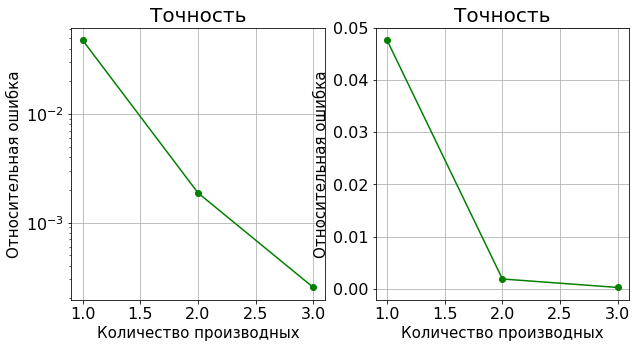

In [66]:
err = [np.abs(dT_act - popt1)/dT_act, np.abs(dT_act - popt2)/dT_act, np.abs(dT_act - popt3)/dT_act]

fig = plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title('Точность', fontsize = 20)
plt.semilogy([1, 2, 3], err, 'go-')
plt.xlabel('Количество производных', fontsize=15)
plt.ylabel('Относительная ошибка', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid()

plt.subplot(122)
plt.title('Точность', fontsize = 20)
plt.plot([1, 2, 3], err, 'go-')
plt.xlabel('Количество производных', fontsize=15)
plt.ylabel('Относительная ошибка', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.grid()